In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp

In [2]:
def plot_path(fig,cart_path,xlim=[-5,5],ylim=[-5,5],color='red',scatter=0):
    path = cart_path
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
    if(scatter==1):
        fig.scatter(path[:,0],path[:,1],c=color,edgecolors='black',s=40,marker="o",label='input')
        # num_step = len(target)
        # plt.scatter(path[num_step-1,0],path[num_step-1,1],c="yellow",s=500,marker="*")
    else:
        x = path[0:len(path)-1,0]
        y = path[0:len(path)-1,1]
        u = path[1:len(path),0] - x
        v = path[1:len(path),1] - y
        fig.quiver(x,y,u,v, scale_units='xy', angles='xy', scale=1,color=color, width=0.003)
    fig.set_xlabel("x[m]")
    fig.set_ylabel("y[m]")
    fig.axis('scaled')
    #fig.set_xlim(xlim[0],xlim[1])
    #fig.set_ylim(ylim[0],ylim[1])
    #fig.set_xlim(min(path[:,0]),max(path[:,0]))
    #fig.set_ylim(min(path[:,1]),max(path[:,1]))
    fig.grid()
    return fig

In [3]:
# loss
def error_squares(z_oplus,z_true):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'    
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_distance) + '\t'
    '''
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_distance) + '\t'
    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [4]:
# dataset
DATA_SIZE = 5000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_V_STEP = 0.5 / DATA_NUM_WAYPOINTS # [m/step]
DATA_MAX_V_STEP = 1.0 / DATA_NUM_WAYPOINTS # [m/step]
DATA_W_STEP = xp.pi * 0.5 / DATA_NUM_WAYPOINTS # [rad/step]
DATA_MAX_W_STEP = xp.pi * 0.5 / DATA_NUM_WAYPOINTS # [rad/step]
DATA_RANGE_TRANSLATE = 0 # 0.03 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 0.1 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :5000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.05
DATA_MAX_V_STEP      :0.1
DATA_W_STEP          :0.15707963267948966
DATA_MAX_W_STEP      :0.15707963267948966
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [5]:

modelname = [
    'Model30mm10step_201910231838_5000data15ep/Model30mm10step_201910231838_5000data15ep.model',
    'Model30mm10step_201910241950_5000data15ep/Model30mm10step_201910241950_5000data15ep.model',
    'Model30mm10step_201911041602_1000data10ep/Model30mm10step_201911041602_1000data10ep.model',
    'Model30mm10step_201911041624_1000data10ep/Model30mm10step_201911041624_1000data10ep.model'
    # 'Model30mm10step_201910152000_5000data5ep/Model30mm10step_201910152000_5000data5ep.model',
    # 'Model30mm10step_201910211942_5000data30ep/Model30mm10step_201910211942_5000data30ep.model'
]
modelname = [ 'backup20191105/Model50mm10step_201911041801_1000data10ep/Model50mm10step_201911041801_1000data10ep.model']

modelcolors = [
    'blue',
    'skyblue',
    'green',
    'yellowgreen',
    'purple',
    'magenta',
    'hotpink'
]
models = [Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP) for i in range(len(modelname))]
for i in range(len(models)):
    serializers.load_npz(modelname[i],models[i])
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        models[i].to_gpu(settings.gpu_index)

In [6]:
def predict(model,x):
    y_v, y_w = model(x)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((y_v,pad,y_w),axis=2)
    loss = loss_function(y_pad, x_test)
    z_oplus = xp.array([x.data for x in calc_oplus(y_pad)],dtype=xp.float32)
    return y_pad, loss, z_oplus

def predict_clip(model,x):
    y_v, y_w = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.clip(y_v,0.0,v_limit)
    w = F.clip(y_w,-w_limit,w_limit)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((v,pad,w),axis=2)
    #pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
    #y_pad = F.concat((y,pad),axis=2)
    #y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    loss = loss_function(y_pad, x_test)
    z_oplus = xp.array([x.data for x in calc_oplus(y_pad)],dtype=xp.float32)
    return y_pad, loss, z_oplus

input_A = -0.11065764846116538 rad/step
model_A = backup20191105/Model50mm10step_201911041801_1000data10ep/Model50mm10step_201911041801_1000data10ep.model

 ------------------------------------------------------ 
-0.11065764846116538
-0.11065


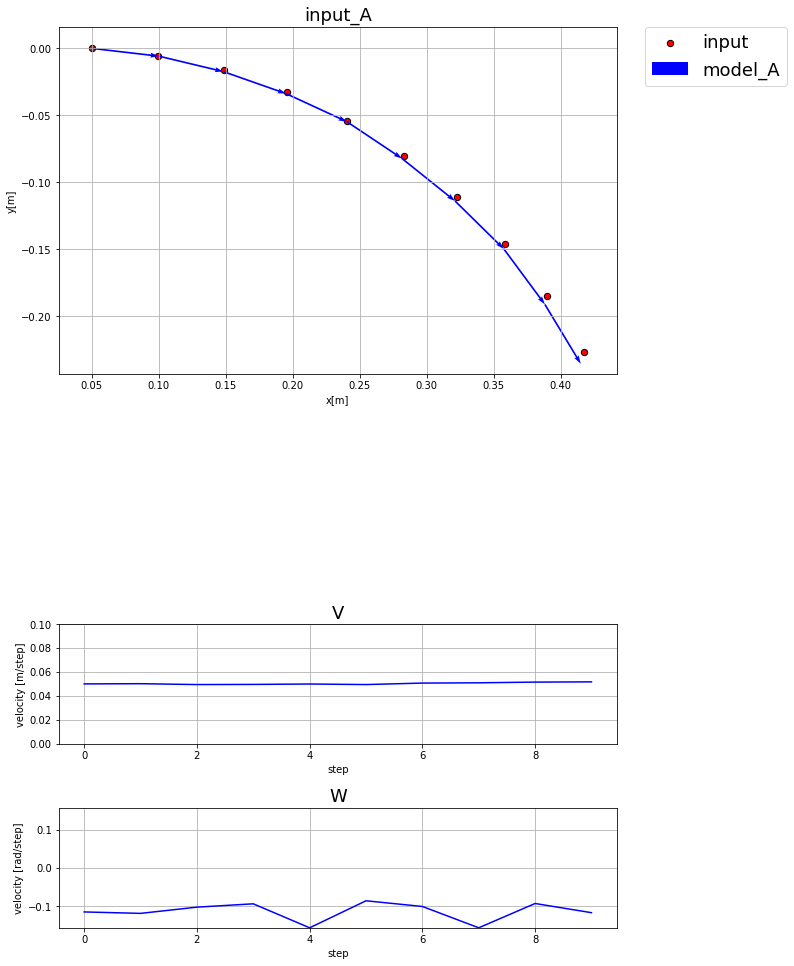

average_loss : 0.027993798


In [7]:
#rad = xp.linspace(-DATA_RAD_PER_STEP, DATA_RAD_PER_STEP, 73) # -36 ~ 36 m/step
#rad = xp.linspace(-xp.deg2rad(5),xp.deg2rad(5), 15)
rad = xp.linspace(-DATA_W_STEP, DATA_W_STEP, 15) # -36 ~ 36 m/step
panels = ['loss','v_1','w_1' ,'average_v','average_w']
columns = ['model_'+chr(ord('A')+x) for x in range(len(modelname))]
#columns = [x.split('/')[0] for x in modelname]
rows = [float(x) for x in rad]
rows_name = ['input_'+chr(ord('A')+x) for x in range(len(rad))]
for i in range(len(rows)):
    print(str(rows_name[i])+' = '+ str(rows[i])+' rad/step')
for i in range(len(modelname)):
    print(columns[i]+ ' = '+modelname[i])

loss_df = pd.DataFrame(index=rows, columns=columns)
v_1_df = pd.DataFrame(index=rows, columns=columns)
w_1_df = pd.DataFrame(index=rows, columns=columns)
ave_v_df = pd.DataFrame(index=rows, columns=columns)
ave_w_df = pd.DataFrame(index=rows, columns=columns)
for i in range(len(rad)):
    print('\n ------------------------------------------------------ ')
    Y = []
    fig ,axes = plt.subplots(3,1, gridspec_kw={'height_ratios': [6,1,1]},figsize=(10,20))
    plt.subplots_adjust(wspace=0, hspace=0.2)
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(1,1,1)
    d = data.generate_arc_path(DATA_NUM_STEP,rad[i],DATA_V_STEP)
    #print(DATA_NUM_STEP,rad[i],DATA_V_STEP)
    #print(d)
    d = data.rotate_path(d,rad[i]*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    x_test = d
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    axes[0] = plot_path(axes[0],x_test,xlim=[-.1,.5],ylim=[-.2,.2],scatter=1)
    for j in range(len(models)):
        y, loss, z_oplus = predict_clip(models[j],x)
        Y.append(y.data)
        mean_v = xp.mean(y.data[0,:,0])
        mean_w = xp.mean(y.data[0,:,2])
        loss_df.iat[i,j] = loss.data
        ave_v_df.iat[i,j] = mean_v
        ave_w_df.iat[i,j] = mean_w
        v_1_df.iat[i,j] = y.data[0,0,0]
        w_1_df.iat[i,j] = y.data[0,0,2]
        axes[0] = plot_path(axes[0], z_oplus,xlim=[-.1,.5],ylim=[-.2,.2],color=modelcolors[j])
        if(settings.gpu_index >= 0):
            y_np = xp.asnumpy(y.data)
        margin = 0.0
        axes[1].plot(y_np[0,:,0],color=modelcolors[j])
        axes[1].set_ylim([0,DATA_MAX_V_STEP+margin])
        axes[1].set_title('V', fontsize=18)
        axes[1].set_ylabel('velocity [m/step]')
        axes[1].set_xlabel('step')
        axes[1].grid()
        margin = 0.0
        axes[2].plot(y_np[0,:,2],color=modelcolors[j])
        axes[2].set_ylim([-DATA_MAX_W_STEP-margin,DATA_MAX_W_STEP+margin])
        axes[2].set_ylabel('velocity [rad/step]')
        axes[2].set_xlabel('step')
        axes[2].set_title('W', fontsize=18)
        axes[2].grid()
    leg = columns.copy()
    leg.insert(0,'input')
    axes[0].legend(leg,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    axes[0].grid()
    axes[0].set_title(rows_name[i], fontsize=18)
    plt.pause(0.01)
    print('average_loss :', loss.data)
    plt.show()

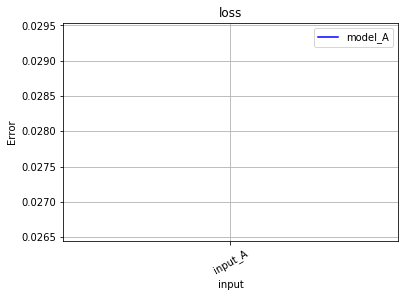

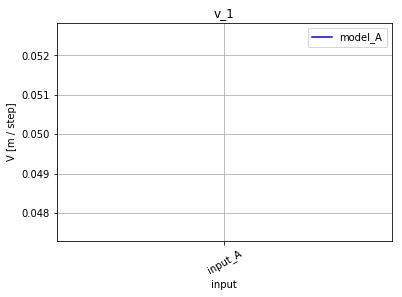

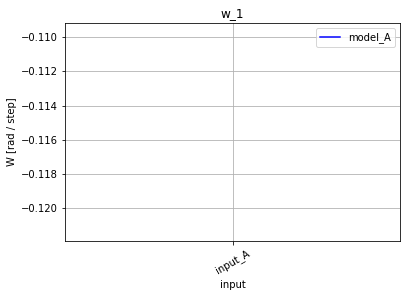

"\n# print(v_df)\nave_v_df.plot(title='average v')\nplt.xticks(rows,rows_name,rotation=30)\nplt.ylabel('v [m / step]')\nplt.xlabel('input')\nplt.grid()\nplt.show()\n# print(v_df)\nave_w_df.plot(title='average ω')\nplt.xticks(rows,rows_name,rotation=30)\nplt.ylabel('loss')\nplt.ylabel('ω [rad / step]')\nplt.xlabel('input')\nplt.grid()\nplt.show()\n# print(w_df)\n"

In [9]:
loss_df = loss_df.astype(float)
ave_v_df = ave_v_df.astype(float)
ave_w_df = ave_w_df.astype(float)
v_1_df = v_1_df.astype(float)
w_1_df = w_1_df.astype(float)

loss_df.plot(title='loss',color=modelcolors)
plt.xticks(rows,rows_name,rotation=30)
plt.ylabel('Error')
plt.xlabel('input')
plt.grid()
plt.show()
# print(loss_df)
v_1_df.plot(title='v_1',color=modelcolors)
plt.xticks(rows,rows_name,rotation=30)
margin = 0.01
#plt.ylim([0,DATA_M_PER_STEP+margin])
plt.ylabel('V [m / step]')
plt.xlabel('input')
plt.grid()
plt.show()
# print(v_df)
w_1_df.plot(title='w_1',color=modelcolors)
plt.xticks(rows,rows_name,rotation=30)
margin = 0
#plt.ylim([-DATA_RAD_PER_STEP-margin,DATA_RAD_PER_STEP+margin])
plt.ylabel('W [rad / step]')
plt.xlabel('input')
plt.grid()
plt.show()
'''
# print(v_df)
ave_v_df.plot(title='average v')
plt.xticks(rows,rows_name,rotation=30)
plt.ylabel('v [m / step]')
plt.xlabel('input')
plt.grid()
plt.show()
# print(v_df)
ave_w_df.plot(title='average ω')
plt.xticks(rows,rows_name,rotation=30)
plt.ylabel('loss')
plt.ylabel('ω [rad / step]')
plt.xlabel('input')
plt.grid()
plt.show()
# print(w_df)
'''

In [10]:
print('loss')
print(loss_df)
print('\nv_1')
print(v_1_df)
print('\nw_1')
print(w_1_df)
'''
print('\naverage v')
print(ave_v_df)
print('\naverage w')
print(ave_w_df)
'''

loss
            model_A
-0.110658  0.027994

v_1
            model_A
-0.110658  0.050065

w_1
            model_A
-0.110658 -0.115534


"\nprint('\naverage v')\nprint(ave_v_df)\nprint('\naverage w')\nprint(ave_w_df)\n"